In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import pandas as pd
import numpy as np  
from scipy.stats import rankdata
from scipy import stats
import sys

## Spatially and temporally varying interventions

Differences in the time required for an apoptotic agent to bring about cell death in our model are accounted for by how long signals from the affected nodes and edges of the internal regulatory network take to propogate to the apoptosis node. This signal delay also plays a role in the time required for a cell that has only partially committed to apoptosis to recover once the apoptotic substrate is removed. These two lag effects can combine in counterintuitive ways under periodic dosing. Fast interventions that initially appear to be more effective can fall behind slower interventions that initially kill fewer cells.

(lets describe the simulation eventually. For example, this exepriment includes a range of clearances)

### Load and process live cell data

This model includes only one population - so we extracted the live cells from each simulation time output. This data was placed in a CSV file. 

Here we load this into a dataframe, (no mean here) and finally plot all time courses. 

In [2]:
df_raw = pd.read_csv('../dataframes/aggregated_live_cells_time_and_space.csv', index_col=0)
df_raw.head()

,0.0,12.0,24.0,36.0,48.0,60.0,72.0,84.0,96.0,108.0,...,9972.0,9984.0,9996.0,10008.0,10020.0,10032.0,10044.0,10056.0,10068.0,10080.0
intervention,,,,,,,,,,,,,,,,,,,,,
EG_Ceramide_S1P_1_11,1344,1347,1348,1351,1354,1355,1356,1359,1360,1361,...,1633,1633,1633,1633,1633,1633,1633,1634,1634,1634
EG_Ceramide_S1P_1_21,1344,1346,1350,1353,1354,1355,1355,1357,1358,1359,...,1230,1230,1231,1231,1231,1231,1232,1232,1233,1235
EG_Ceramide_S1P_1_31,1344,1346,1346,1347,1350,1350,1351,1354,1355,1356,...,820,822,822,822,822,822,822,822,822,823
EG_GAP_RAS_1_11,1344,1346,1348,1349,1352,1354,1355,1357,1359,1361,...,1729,1729,1729,1730,1730,1730,1730,1730,1730,1730
EG_GAP_RAS_1_21,1344,1347,1349,1350,1352,1353,1357,1358,1360,1361,...,1307,1309,1310,1310,1310,1310,1311,1311,1311,1311


We will mainly be using the transpose of `raw` so lets transpose it. 

In [3]:
df = df_raw.transpose()
df.head(100)

intervention,EG_Ceramide_S1P_1_11,EG_Ceramide_S1P_1_21,EG_Ceramide_S1P_1_31,EG_GAP_RAS_1_11,EG_GAP_RAS_1_21,EG_GAP_RAS_1_31,EG_IL15_GAP_0_11,EG_IL15_GAP_0_21,EG_IL15_GAP_0_31,EG_IL2RBT_IL2RB_0_11,...,SM_pro_Ceramidepro_PI3Kpro_ERK_31,SM_pro_Ceramidepro_PI3Kpro_MEK_11,SM_pro_Ceramidepro_PI3Kpro_MEK_21,SM_pro_Ceramidepro_PI3Kpro_MEK_31,SM_pro_Ceramidepro_RAS_11,SM_pro_Ceramidepro_RAS_21,SM_pro_Ceramidepro_RAS_31,SM_pro_TBETpro_Ceramidepro_ERK_11,SM_pro_TBETpro_Ceramidepro_ERK_21,SM_pro_TBETpro_Ceramidepro_ERK_31
0.0,1344,1344,1344,1344,1344,1344,1344,1344,1344,1344,...,1344,1344,1344,1344,1344,1344,1344,1344,1344,1344
12.0,1347,1346,1346,1346,1347,1347,1346,1344,1346,1347,...,1344,1344,1349,1346,1345,1346,1346,1346,1347,1348
24.0,1348,1350,1346,1348,1349,1349,1350,1347,1348,1348,...,1346,1345,1350,1347,1346,1347,1346,1348,1348,1348
36.0,1351,1353,1347,1349,1350,1349,1351,1349,1351,1350,...,1349,1348,1351,1347,1350,1349,1349,1351,1349,1349
48.0,1354,1354,1350,1352,1352,1350,1355,1351,1352,1350,...,1350,1351,1353,1347,1351,1349,1353,1352,1351,1350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140.0,1429,1140,1025,1455,1271,1087,1479,1269,1118,1444,...,1021,1439,1124,1008,1396,1116,1027,1397,1126,1019
1152.0,1431,1140,1025,1455,1271,1087,1480,1270,1118,1445,...,1023,1441,1127,1008,1398,1117,1028,1398,1127,1020
1164.0,1433,1141,1027,1457,1273,1088,1482,1273,1119,1445,...,1024,1442,1129,1011,1400,1118,1029,1399,1128,1020
1176.0,1434,1143,1027,1457,1274,1089,1482,1273,1119,1445,...,1025,1444,1130,1012,1400,1118,1030,1402,1130,1020


Now we have something to plot! Lets chck them out!!

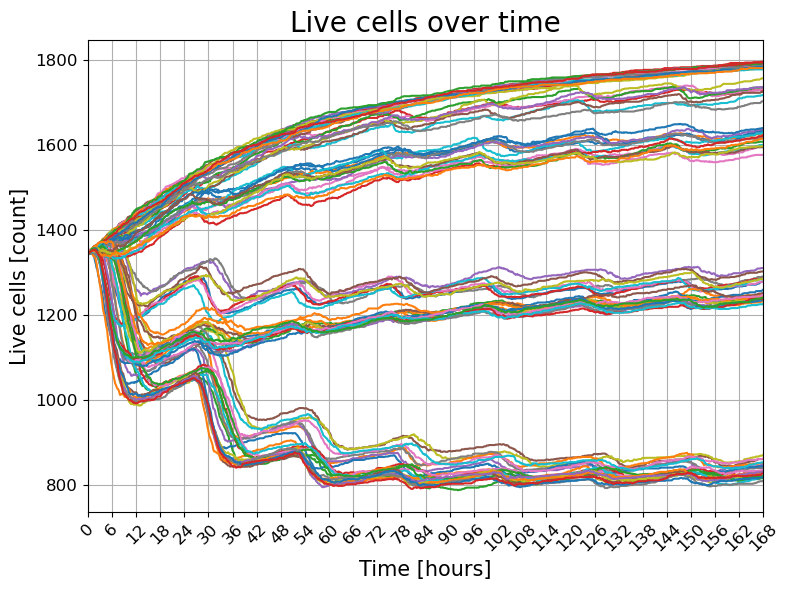

In [4]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(8, 6))

for intervention in df:
    plt.plot(df.index, df[intervention])

plt.title('Live cells over time', fontsize=20)
plt.xlabel('Time [hours]', fontsize=15)
plt.ylabel('Live cells [count]', fontsize=15)
# plt.ylim(0, 3200)
plt.xlim(0, df.index[-1])
ticks = np.arange(0, len(df.index), 30)
plt.xticks(ticks, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='both', which='both')
# Use set_major_formatter to format ticks as hours

def fmt_index_to_hours(x, pos):
    x = x / 5  # 1/5 of an hour OR 12 minutes per index
    return f'{x:.0f}'

ax.xaxis.set_major_formatter(ticker.FuncFormatter(fmt_index_to_hours))
plt.tight_layout()
plt.savefig('../figures/spatial__and_time_all_time_courses.png', dpi=600)
plt.show()

### Add in the pulses

These simulations include concentrations that vary over time. So, we will include just the time when pulses restart. It is worth noting that at the slower clearance rates (the boundary condition takes longer to reach a 0 value), there is accumulation - so later pulses have more time/space above the activation threshold. 

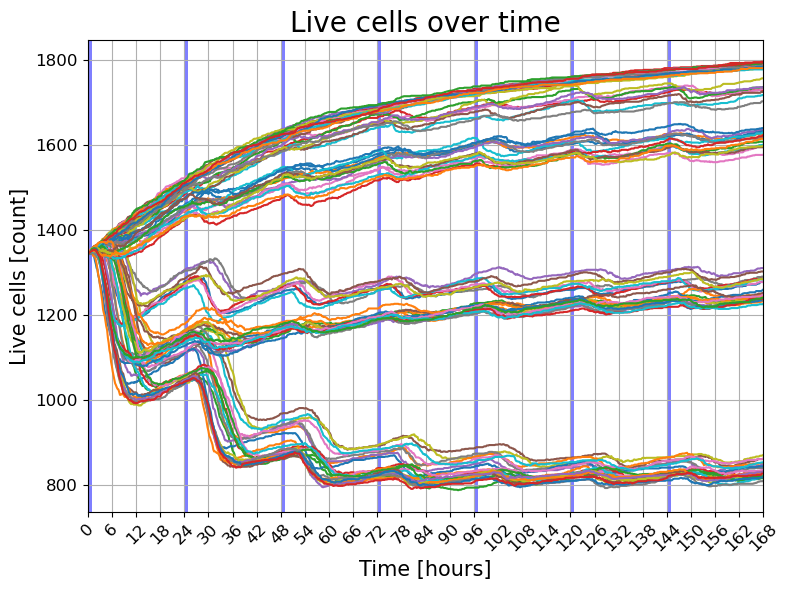

In [5]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(8, 6))

for intervention in df:
    plt.plot(df.index, df[intervention])

plt.title('Live cells over time', fontsize=20)
plt.xlabel('Time [hours]', fontsize=15)
plt.ylabel('Live cells [count]', fontsize=15)
# plt.ylim(0, 3200)
plt.xlim(0, df.index[-1])
ticks = np.arange(0, len(df.index), 30)
plt.xticks(ticks, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='both', which='major')
# Use set_major_formatter to format ticks as hours

def fmt_index_to_hours(x, pos):
    x = x / 5  # 1/5 of an hour OR 12 minutes per index
    return f'{x:.0f}'

ax.xaxis.set_major_formatter(ticker.FuncFormatter(fmt_index_to_hours))

# put these in a loop to color code the different time periods - every 24 hours.
for tick in ticks[0::4]:
    plt.axvspan(tick, tick+5, facecolor='blue', alpha=0.5, linewidth=6)


plt.tight_layout()
plt.savefig('../figures/spatial__and_time_all_time_courses.png', dpi=600)
plt.show()



### Lets break this down by scenario - looking for patterns and generally making the data more seeable

In the pulsed interveal analysis, we broke the data down several ways. Lets start here though by just breaking it down completely - making an array of each kind of simulation:
- Fast, medium, or slow clearance
- Edgetic, IBMFA, and stable motif target control algorithm



In [6]:
# Alter the dataframe - remove the last digit from the column names

column_remapped = [x[:-1] for x in df.columns]
df.columns = column_remapped

print(df.shape)
df.head()

(841, 84)


,EG_Ceramide_S1P_1_1,EG_Ceramide_S1P_1_2,EG_Ceramide_S1P_1_3,EG_GAP_RAS_1_1,EG_GAP_RAS_1_2,EG_GAP_RAS_1_3,EG_IL15_GAP_0_1,EG_IL15_GAP_0_2,EG_IL15_GAP_0_3,EG_IL2RBT_IL2RB_0_1,...,SM_pro_Ceramidepro_PI3Kpro_ERK_3,SM_pro_Ceramidepro_PI3Kpro_MEK_1,SM_pro_Ceramidepro_PI3Kpro_MEK_2,SM_pro_Ceramidepro_PI3Kpro_MEK_3,SM_pro_Ceramidepro_RAS_1,SM_pro_Ceramidepro_RAS_2,SM_pro_Ceramidepro_RAS_3,SM_pro_TBETpro_Ceramidepro_ERK_1,SM_pro_TBETpro_Ceramidepro_ERK_2,SM_pro_TBETpro_Ceramidepro_ERK_3
0.0,1344,1344,1344,1344,1344,1344,1344,1344,1344,1344,...,1344,1344,1344,1344,1344,1344,1344,1344,1344,1344
12.0,1347,1346,1346,1346,1347,1347,1346,1344,1346,1347,...,1344,1344,1349,1346,1345,1346,1346,1346,1347,1348
24.0,1348,1350,1346,1348,1349,1349,1350,1347,1348,1348,...,1346,1345,1350,1347,1346,1347,1346,1348,1348,1348
36.0,1351,1353,1347,1349,1350,1349,1351,1349,1351,1350,...,1349,1348,1351,1347,1350,1349,1349,1351,1349,1349
48.0,1354,1354,1350,1352,1352,1350,1355,1351,1352,1350,...,1350,1351,1353,1347,1351,1349,1353,1352,1351,1350


In [7]:
df_transpose = df.transpose()
df_transpose.head()

,0.0,12.0,24.0,36.0,48.0,60.0,72.0,84.0,96.0,108.0,...,9972.0,9984.0,9996.0,10008.0,10020.0,10032.0,10044.0,10056.0,10068.0,10080.0
EG_Ceramide_S1P_1_1,1344,1347,1348,1351,1354,1355,1356,1359,1360,1361,...,1633,1633,1633,1633,1633,1633,1633,1634,1634,1634
EG_Ceramide_S1P_1_2,1344,1346,1350,1353,1354,1355,1355,1357,1358,1359,...,1230,1230,1231,1231,1231,1231,1232,1232,1233,1235
EG_Ceramide_S1P_1_3,1344,1346,1346,1347,1350,1350,1351,1354,1355,1356,...,820,822,822,822,822,822,822,822,822,823
EG_GAP_RAS_1_1,1344,1346,1348,1349,1352,1354,1355,1357,1359,1361,...,1729,1729,1729,1730,1730,1730,1730,1730,1730,1730
EG_GAP_RAS_1_2,1344,1347,1349,1350,1352,1353,1357,1358,1360,1361,...,1307,1309,1310,1310,1310,1310,1311,1311,1311,1311


Make categories dataframe - getting the algorithm and decay

In [46]:
df_categories = pd.DataFrame(index=df_transpose.index)

# Need to split index into a name. For the EGs, the name will be the second and third elements connected by a right arrow. Then an "=" and the second to last element. 
# for the others we have "pro" and "anti". These are node level interventions. We need it to be "Node=pro" or "Node=anti", where pro is 1 and anti is 0.
# The biggest issue is that the non-EGs are not split by an underscore. So we need to do some string matching to get the right values. In particular, 
# the nodes of some are right next to the "pro" or "anti" and some are not.
# Not completely handled - but working for now. 

# Gets intervnetion name/label from the index
for index in df_transpose.index:
    split_index = index.split('_', 10)
    # print(split_index)
    if split_index[0] == 'EG':
        df_categories.loc[index, 'intervention_name'] = f'{split_index[1]}->{split_index[2]}={split_index[-2]}'
    
    # ASSUMES ONLY SINGLE NODE INTERVENTIONS!!!!
    elif split_index[0] == 'IB':
        if split_index[1] == 'pro':
            df_categories.loc[index, 'intervention_name'] = f'{split_index[2]}=1'
        else:
            df_categories.loc[index, 'intervention_name'] = f'{split_index[2]}=0'
    # the final category includes having the node name right next to the pro or anti. How do we pull the pro or anti out?
    # Will have to do some substring matching/searching to find them
    else:
        if len(split_index) < 5:
            if 'pro' in split_index[1]:
                df_categories.loc[index, 'intervention_name'] = f'{split_index[2]}=1'
            else:
                df_categories.loc[index, 'intervention_name'] = f'{split_index[2]}=0'
        # This handles the ones iwth multiple nodes. Its a bit of a mess. It can be generalized, probably, but the easiest fix is to change out how the names output. 
        else:
            if len(split_index) == 5:
                for item in split_index[1:]:
                    if 'pro' in split_index[1]:
                        temp = split_index[2].replace('pro', '')
                        temp_str = f'{temp}=1, '
                    if 'pro' in split_index[2]:
                        temp_str += f'{split_index[3]}=1'
                df_categories.loc[index, 'intervention_name'] = temp_str
            else:
                if 'pro' in split_index[1]:
                    temp = split_index[2].replace('pro', '')
                    temp_str = f'{temp}=1, '
                if 'pro' in split_index[2]:
                    temp = split_index[3].replace('pro', '')
                    temp_str += f'{temp}=1, '
                if 'pro' in split_index[3]:
                    temp_str += f'{split_index[4]}=1'
                df_categories.loc[index, 'intervention_name'] = temp_str

                    
# Gets the algorithm and decay from the index

for index in df_transpose.index:
    split_index = index.split('_', 10)
    df_categories.loc[index, 'algorithm'] = split_index[0]
    df_categories.loc[index, 'decay'] = split_index[-1]
    # df_temp.loc[index, 'type'] = split_index[-2] # this would involve string matching to really do right (pro = 1, anti=0)


df_categories.head(200)

,intervention_name,algorithm,decay
EG_Ceramide_S1P_1_1,Ceramide->S1P=1,EG,1
EG_Ceramide_S1P_1_2,Ceramide->S1P=1,EG,2
EG_Ceramide_S1P_1_3,Ceramide->S1P=1,EG,3
EG_GAP_RAS_1_1,GAP->RAS=1,EG,1
EG_GAP_RAS_1_2,GAP->RAS=1,EG,2
...,...,...,...
SM_pro_Ceramidepro_RAS_2,"Ceramide=1, RAS=1",SM,2
SM_pro_Ceramidepro_RAS_3,"Ceramide=1, RAS=1",SM,3
SM_pro_TBETpro_Ceramidepro_ERK_1,"TBET=1, Ceramide=1, ERK=1",SM,1
SM_pro_TBETpro_Ceramidepro_ERK_2,"TBET=1, Ceramide=1, ERK=1",SM,2


Remember - here we are jsut going with the complete break down first. So they are split out into each indvidual category.

In [9]:
df_fast_EG = df_categories[(df_categories.decay == '1') & (df_categories.algorithm == 'EG')].transpose()

df_medium_EG = df_categories[(df_categories.decay == '2') & (df_categories.algorithm == 'EG')].transpose()

df_slow_EG = df_categories[(df_categories.decay == '3') & (df_categories.algorithm == 'EG')].transpose()

df_fast_IB = df_categories[(df_categories.decay == '1') & (df_categories.algorithm == 'IB')].transpose()

df_medium_IB = df_categories[(df_categories.decay == '2') & (df_categories.algorithm == 'IB')].transpose()

df_slow_IB = df_categories[(df_categories.decay == '3') & (df_categories.algorithm == 'IB')].transpose()

df_fast_SM = df_categories[(df_categories.decay == '1') & (df_categories.algorithm == 'SM')].transpose()

df_medium_SM = df_categories[(df_categories.decay == '2') & (df_categories.algorithm == 'SM')].transpose()

df_slow_SM = df_categories[(df_categories.decay == '3') & (df_categories.algorithm == 'SM')].transpose()

In [10]:
individual_categories = {}
individual_categories = {'df_Fast_EG': df_fast_EG, 'df_Medium_EG': df_medium_EG, 'df_Slow_EG': df_slow_EG, 'df_Fast_IB': df_fast_IB, 
                         'df_Medium_IB': df_medium_IB, 'df_Slow_IB': df_slow_IB, 'df_Fast_SM': df_fast_SM, 'df_Medium_SM': df_medium_SM, 'df_Slow_SM': df_slow_SM}

In [11]:
for key in individual_categories:
    print(key.split('_'))

['df', 'Fast', 'EG']
['df', 'Medium', 'EG']
['df', 'Slow', 'EG']
['df', 'Fast', 'IB']
['df', 'Medium', 'IB']
['df', 'Slow', 'IB']
['df', 'Fast', 'SM']
['df', 'Medium', 'SM']
['df', 'Slow', 'SM']


In [12]:
def plot_category_array(df_name: str, df: object, df_avg, ax):
    split_category_name = df_name.split('_')
    title = f'{split_category_name[1]} Clearance {split_category_name[2]} Only: Cell populations'
    # fig, ax = plt.subplots(figsize=(8, 6))
    linestyles = ['solid', 'dotted', 'dashed', 'dashdot', (0, (3, 1, 1, 1, 1, 1)), (5, (10, 3)), (0, (5, 1)), (0, (3, 10, 1, 10)), (0, (3, 5, 1, 5, 1, 5)), (0, (3, 1, 1, 1)), (0, (5, 10))] 
    for i, intervention in enumerate(df): 
        ax.plot(df_avg.index, df_avg[intervention], label=df[intervention]['intervention_name'], linestyle=linestyles[i]) # tried to make a marker here - but it didn't work. Markers are too dense. I could try line style. I think though I am about done. 

    ax.set_title(title, fontsize=15)
    ax.set_xlabel('Time [hours]', fontsize=12)
    ax.set_ylabel('Live cells [count]', fontsize=12)
    ax.set_xlim(0, df_avg.index[-1])
    ax.set_ylim(500, 2000)
    ticks = np.arange(0, len(df_avg.index), 60)
    # ax.set_xticks(ticks, rotation=45, fontsize=10)
    ax.set_xticks(ticks, minor=False)
    # ax.set_yticks(fontsize=10)

    # Use set_major_formatter to format ticks as hours

    def fmt_index_to_hours(x, pos):
        x = x / 5  # 1/5 of an hour OR 12 minutes per index
        return f'{x:.0f}'

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(fmt_index_to_hours))

    # put these in a loop to color code the different time periods - every 24 hours.
    for tick in ticks[0::2]:
        ax.axvspan(tick, tick+5, facecolor='blue', alpha=0.25, linewidth=6)

    ##### WARNING - THIS ORDER IS (PROPOSEFULLY) REVERSED FROM ABOVE!!!!!!
    # if split_category_name[1] == 'short':
    #     plt.axvspan(0, 0, facecolor='orange', alpha=0.66, label='Period above threshold: Fast decay', edgecolor='grey', linewidth=1)
    # elif split_category_name[1] == 'medium':
    #     plt.axvspan(0, 0, facecolor='red', alpha=0.25, label='Period above threshold: Medium decay', edgecolor='grey', linewidth=1)
    # elif split_category_name[1] == 'long':
    #     plt.axvspan(0, 0, facecolor='blue', alpha=0.25, label='Period above threshold: Slow decay', edgecolor='grey', linewidth=1)
    if df_name == 'df_Medium_EG':
        ax.legend(loc='lower right', fontsize=8)
    else:
        ax.legend()
    # plt.tight_layout()
    # plt.show()
    return ax

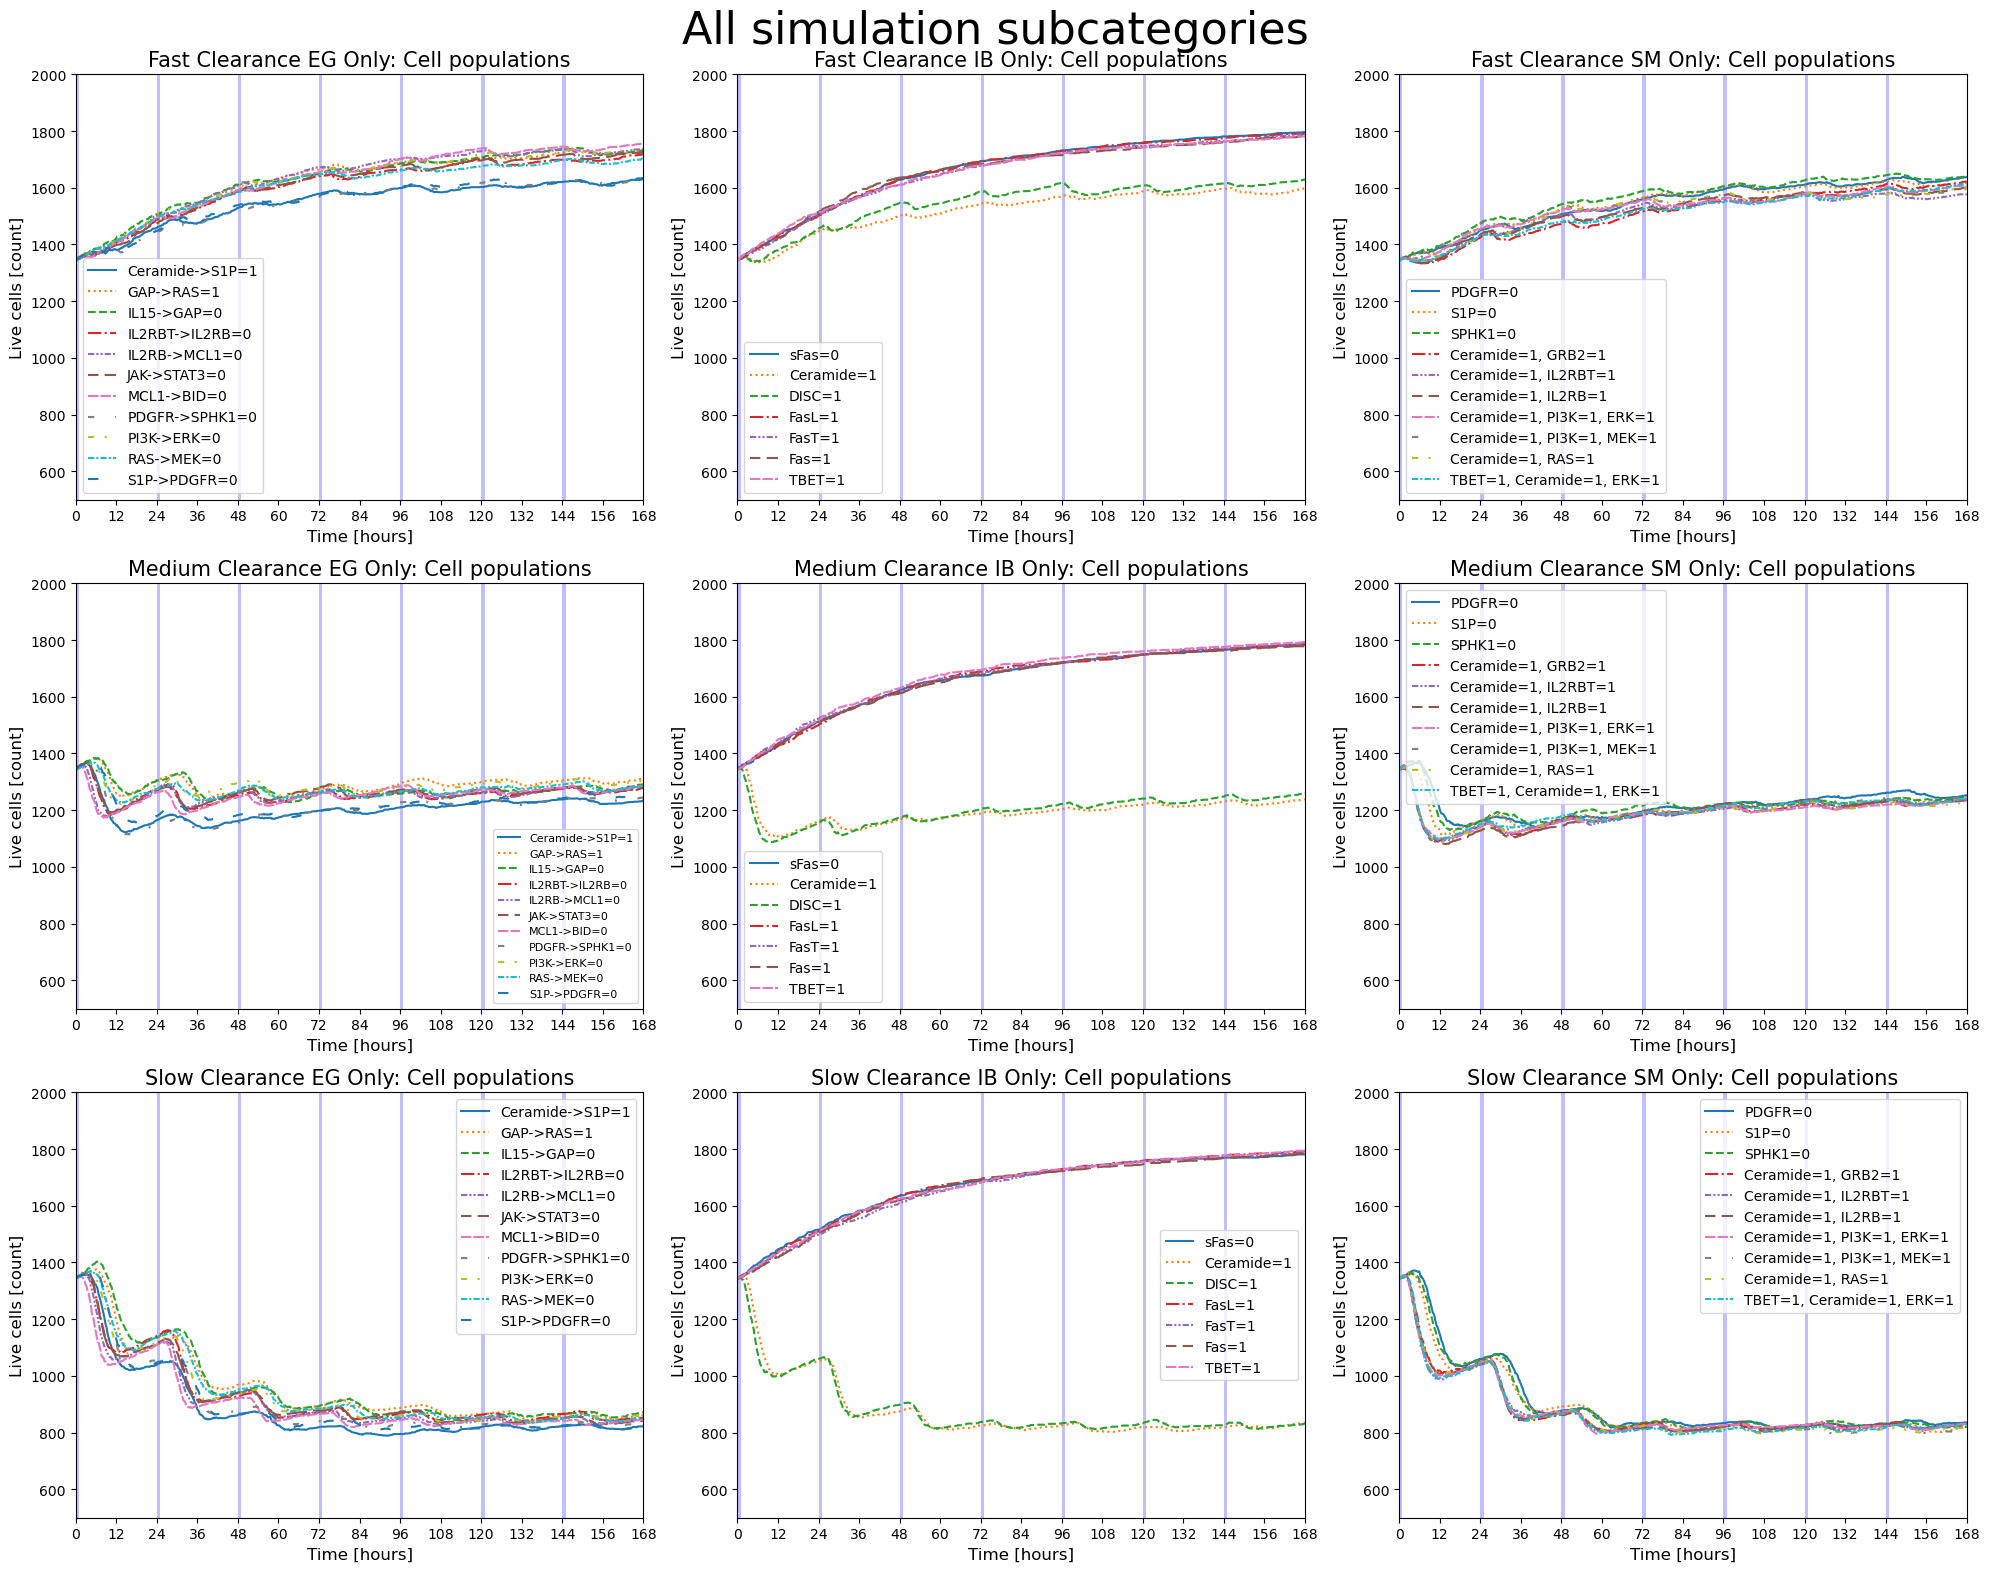

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(20, 16))

for category_name, ax in zip(individual_categories, axes.ravel(order='F')):    
    ax = plot_category_array(category_name, individual_categories[category_name], df, ax)

fig.suptitle('All simulation subcategories', fontsize=32)
plt.tight_layout()
plt.savefig('../figures/all_simulation_subcategories_space_and_time.png', dpi=600)
plt.show()

### Focusing on select time courses with emergent or unexpected out comes

In the middle column, the lower time courses switch rankings. Initially, pro_Ceramide experiences a a higher population decline than pro_DISC. However, by the 4th pulse of the pro-apoptoic substrate, the pro-DISC intervention becomes less effective (higher population). We see this at each level of clearance. Additionally, there is a similar shifting in the edgetic interventions - for exmaple, MCL1_BID_0 is initially more effective than Ceramide_S1P_1 - but ends at a higher value. 

This surprising result, which is due in part to accounting for the time that the interventions take to induce apoptosis, is not observable in a typical BN simulation. In addiiton to accounting for internal timing of the cellular decision process (including the recovery from a partial apoptotic state), these simulations can take into account that an apoptotic cell would actually die (and that it would take some real time to do that and for the cell to recover if it doenst’ die), that single cell-analyses miss. This can lead to population effects, such as a cumulative advantage that can be gained by faster recovery from a partial pro-apopotic state. (would we want to show that in MaBoSS? Can we soften this claim while still making the point?)

Lets pull out just these simulations - we will select the middle clearance,

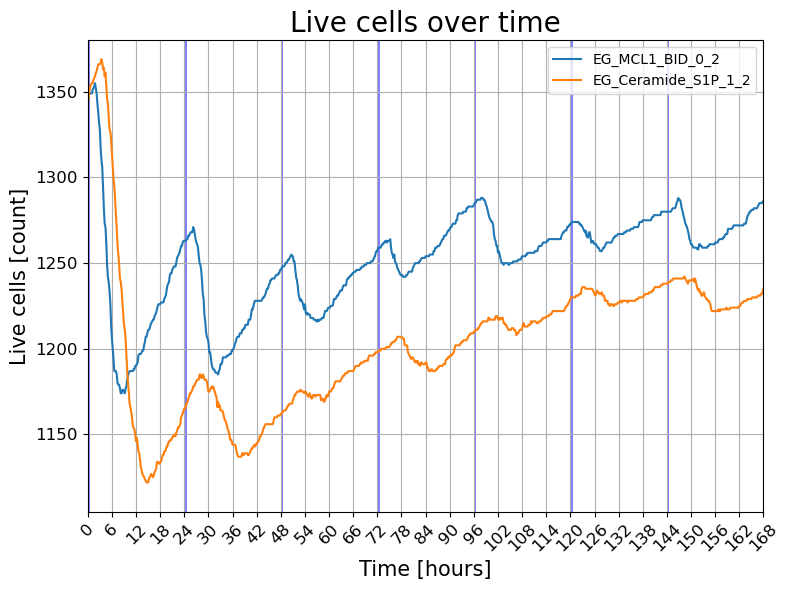

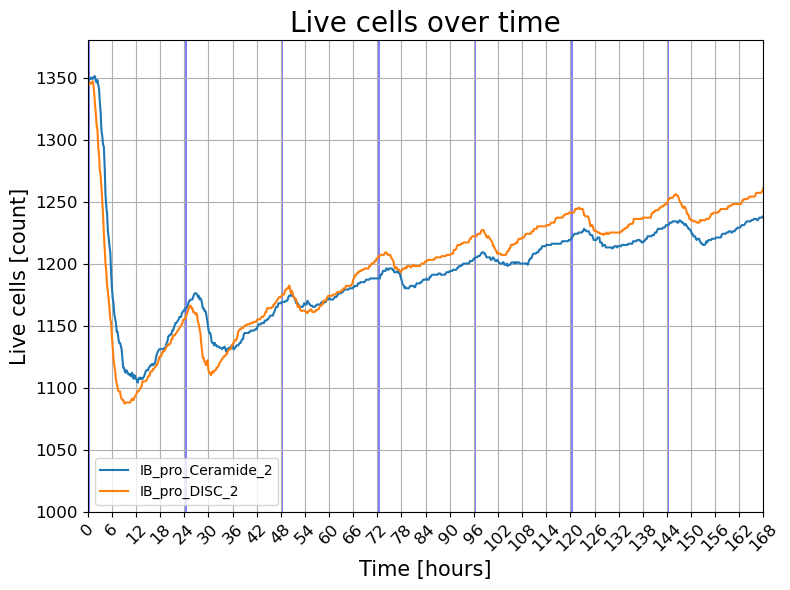

In [14]:
# plot just MCL1_BID_0, Ceramid_S1P_1, pro_Ceramide, and pro_DISC - from the original dataframe. 

focus_list = ['EG_MCL1_BID_0_2', 'EG_Ceramide_S1P_1_2', 'IB_pro_Ceramide_2', 'IB_pro_DISC_2']
focus_list = ['EG_MCL1_BID_0_2', 'EG_Ceramide_S1P_1_2']
focus_list_2 = ['IB_pro_Ceramide_2', 'IB_pro_DISC_2']
# linestyles = ['solid', 'dotted', 'dashed', 'dashdot']
fig, ax = plt.subplots(figsize=(8, 6))
# for intervention, linestyle in zip(focus_list, linestyles):
#     plt.plot(df.index, df[intervention], linestyle=linestyle, label=intervention)

for intervention in focus_list:
    plt.plot(df.index, df[intervention],  label=intervention)
plt.title('Live cells over time', fontsize=20)
plt.xlabel('Time [hours]', fontsize=15)
plt.ylabel('Live cells [count]', fontsize=15)
plt.xlim(0, df.index[-1])
plt.ylim(1105, 1380)
ticks = np.arange(0, len(df.index), 30)
plt.xticks(ticks, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='both', which='both')
# Use set_major_formatter to format ticks as hours

def fmt_index_to_hours(x, pos):
    x = x / 5  # 1/5 of an hour OR 12 minutes per index
    return f'{x:.0f}'

ax.xaxis.set_major_formatter(ticker.FuncFormatter(fmt_index_to_hours))

# put these in a loop to color code the different time periods - every 24 hours.
for tick in ticks[0::4]:
    plt.axvspan(tick, tick+3, facecolor='blue', alpha=0.5, linewidth=6)

plt.legend()
plt.tight_layout()
plt.savefig('../figures/focus_interventions_space_and_time_EG.png', dpi=600)
plt.show()

### Second plot - the other two interventions.
fig, ax = plt.subplots(figsize=(8, 6))
for intervention in focus_list_2:
    plt.plot(df.index, df[intervention],  label=intervention)
plt.title('Live cells over time', fontsize=20)
plt.xlabel('Time [hours]', fontsize=15)
plt.ylabel('Live cells [count]', fontsize=15)
plt.xlim(0, df.index[-1])
plt.ylim(1000, 1380)
ticks = np.arange(0, len(df.index), 30)
plt.xticks(ticks, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='both', which='both')
# Use set_major_formatter to format ticks as hours

def fmt_index_to_hours(x, pos):
    x = x / 5  # 1/5 of an hour OR 12 minutes per index
    return f'{x:.0f}'

ax.xaxis.set_major_formatter(ticker.FuncFormatter(fmt_index_to_hours))

# put these in a loop to color code the different time periods - every 24 hours.
for tick in ticks[0::4]:
    plt.axvspan(tick, tick+3, facecolor='blue', alpha=0.5, linewidth=6)
plt.legend()
plt.tight_layout()
plt.savefig('../figures/focus_interventions_space_and_time_IB.png', dpi=600)


## Make more compact charts

Lets focus on the only the fast and slow decays. And we will combine the node interventions into one chart. And remove the redundant ceramide ones (ceramide by it self produces apoptosis - so all the interventions with multiple nodes + ceramide just work - without the other nodes.)

Get the correct focused categories - only the slow and fast decays, putting node interventions together, and removing the redundant ceramide interventions. 

Removing the ceramide ones will be the trick. Just do it manually???

I need to take EVERYTHING in the SM category that contains ceramide out. 

In [15]:
focused_categories = {}

# make new dataframes for SM category that removes any intervnetion that contains Ceramide

df_fast_SM_no_ceramide = pd.DataFrame()
for column in df_fast_SM.columns:
    if 'Ceramide' not in column:
        df_fast_SM_no_ceramide[column] = df_fast_SM[column]

df_slow_SM_no_ceramide = pd.DataFrame()
for column in df_slow_SM.columns:
    if 'Ceramide' not in column:
        df_slow_SM_no_ceramide[column] = df_slow_SM[column]

# make the focused dataframes and dictionary.

df_fast_nodal = pd.concat([df_fast_IB, df_fast_SM_no_ceramide], axis=1)
df_slow_nodal = pd.concat([df_slow_IB, df_slow_SM_no_ceramide], axis=1)

focused_categories = {'df_Fast_EG': df_fast_EG, 'df_Slow_EG': df_slow_EG, 'df_Fast_nodal': df_fast_nodal, 'df_Slow_nodal': df_slow_nodal}

Make new function to plot these specific tracks

In [16]:
def plot_category_array_focused(df_name: str, df, df_avg, ax, subplot_title):
    split_category_name = df_name.split('_')
    # title = f'{split_category_name[1]} Decay {split_category_name[2]} Only: Cell populations'
    title = subplot_title
    # fig, ax = plt.subplots(figsize=(8, 6))
    linestyles = ['solid', 'dotted', 'dashed', 'dashdot', (0, (3, 1, 1, 1, 1, 1)), (5, (10, 3)), (0, (5, 1)), (0, (3, 10, 1, 10)), (0, (3, 5, 1, 5, 1, 5)), (0, (3, 1, 1, 1)), (0, (5, 10))] 
    for i, intervention in enumerate(df): 
        ax.plot(df_avg.index, df_avg[intervention], label=df[intervention]['intervention_name'], linestyle=linestyles[i]) 

    ax.set_title(title, fontsize=15)
    ax.set_xlabel('Time [hours]', fontsize=12)
    ax.set_ylabel('Live cells [count]', fontsize=12)
    ax.set_xlim(0, df_avg.index[-1])
    ax.set_ylim(600, 2000)
    ticks = np.arange(0, len(df_avg.index), 120)
    # ax.set_xticks(ticks, rotation=45, fontsize=10)
    ax.set_xticks(ticks, minor=False)
    # ax.set_yticks(fontsize=10)

    # Use set_major_formatter to format ticks as hours

    def fmt_index_to_hours(x, pos):
        x = x * 12/60 # 12 minutes per index
        return f'{x:.0f}'
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(fmt_index_to_hours))

    # put these in a loop to color code the different time periods - every 24 hours.
    for tick in ticks:
        if split_category_name[1] == 'Fast':
            ax.axvspan(tick, tick+5, facecolor='orange', alpha=0.66, edgecolor='grey', linewidth=1)
        elif split_category_name[1] == 'Medium':
            ax.axvspan(tick, tick+30, facecolor='red', alpha=0.25, edgecolor='grey', linewidth=1)
        elif split_category_name[1] == 'Slow':
            ax.axvspan(tick, tick+60, facecolor='blue', alpha=0.25, edgecolor='grey', linewidth=1)

    ax.legend()
    # plt.tight_layout()
    # plt.show()
    return ax

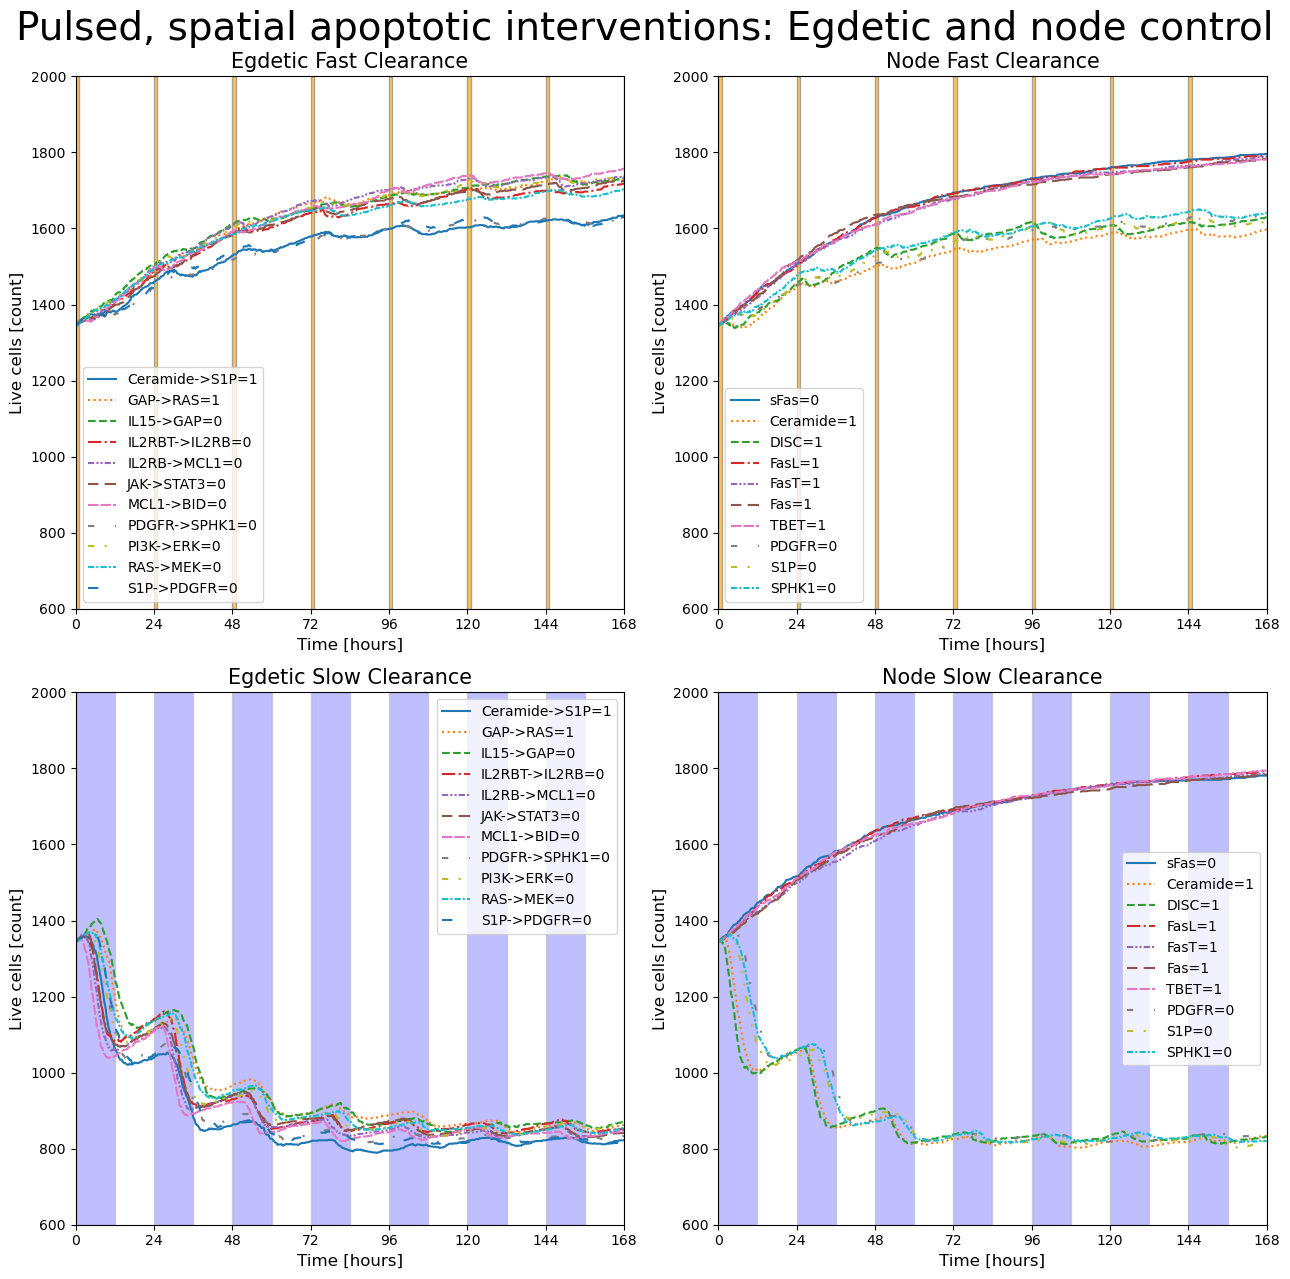

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(13, 13))

subplot_titles = ['Egdetic Fast Clearance', 'Egdetic Slow Clearance', 'Node Fast Clearance', 'Node Slow Clearance']

for category_name, ax, subplot_title in zip(focused_categories, axes.ravel(order='F'), subplot_titles):    
    ax = plot_category_array_focused(category_name, focused_categories[category_name], df, ax, subplot_title)

fig.suptitle('Pulsed, spatial apoptotic interventions: Egdetic and node control', fontsize=28)
plt.tight_layout()
plt.savefig('../figures/pulsed_spatial_edge_and_node_controls.png', dpi=600)
plt.show()

## Area undercurve

We are interested in ranking the interventions. We will get the AUC (total cell count) for the mean of each intervention. 

We already know that the clearance will impact this - so lets split by pulse width. The rankings _should_ be highly correlated. 

The fast clearance has many that just control the population - we aren't trying to charaterize those rankings and we don't hae other experiments to compare them to (the fast decay ones have many tha fail to control the population). Furthremore, we already know that many of the IB predictions fail - so we remove those also. 



In [72]:
# add in the total cell count to the rankings dataframe

from scipy.integrate import trapezoid
# time = df.index.to_numpy()

time = pd.to_numeric(df.index, errors='coerce').tolist()
time = [0 if x<7200 else 1 for x in time]
# get AUC, we need to zero out the column using that as a Boolean mask.
# print(time)

for column in df.columns:
    temp = df[column] * time
    df_categories.loc[column, 'steady_state_cell_count'] = temp.sum()
    # print(df[column]*time)
    # df_categories.loc[column, 'AUC'] = trapezoid(temp.to_numpy(), x=time) # I am not sure I am using this correctly.
    # print(auc)

df_categories['steady_state_cell_count'] = df_categories['steady_state_cell_count'].astype(float)
# df_categories.sort_values(by='steady_state_cell_count', ascending=False).head(40)


In [73]:
# Now we split off the interventions by decay rate

# df_fast_decay_ranking = df_categories[df_categories.decay == '1']

# df_medium_decay_ranking = df_categories.query('decay == 2')
df_medium_clearance_ranking = df_categories[df_categories.decay == '2']
df_medium_clearance_ranking = df_medium_clearance_ranking[df_medium_decay_ranking['steady_state_cell_count']<400000]

df_slow_clearance_ranking = df_categories[df_categories.decay == '3']
df_slow_clearance_ranking = df_slow_clearance_ranking[df_slow_decay_ranking['steady_state_cell_count']<400000]

df_slow_clearance_ranking.shape

(23, 5)

Now - the ranking!

In [74]:
# this generates a warning and won't work (I think) with Pandas 3.0. I tried to follow the example provided in the documentation - and am still getting the warning. I am not sure what is wrong.

# fast
# cell_count_rank = rankdata(df_fast_clearance_ranking['steady_state_cell_count'])
# df_fast_clearance_ranking.loc[:, ('cell_count_rank')] = cell_count_rank
# df_fast_clearance_ranking.to_csv('../dataframes/fast_clearance_time_ranking.csv')

# medium
cell_count_rank = rankdata(df_medium_clearance_ranking['steady_state_cell_count'])
df_medium_clearance_ranking.loc[:, 'cell_count_rank'] = cell_count_rank
df_medium_clearance_ranking.to_csv('../dataframes/medium_clearance_time_ranking.csv')

# slow
cell_count_rank = rankdata(df_slow_clearance_ranking['steady_state_cell_count'])
df_slow_clearance_ranking.loc[:, 'cell_count_rank'] = cell_count_rank
df_slow_clearance_ranking.to_csv('../dataframes/slow_clearance_time_ranking.csv')

In [76]:
# df_fast_clearance_ranking.sort_values(by='cell_count_rank', ascending=False)

In [77]:
df_medium_clearance_ranking.sort_values(by='cell_count_rank', ascending=False)

,intervention_name,algorithm,decay,steady_state_cell_count,AUC,cell_count_rank
EG_GAP_RAS_1_2,GAP->RAS=1,EG,2,313664.0,650.0,23.0
EG_PI3K_ERK_0_2,PI3K->ERK=0,EG,2,311663.0,646.5,22.0
EG_RAS_MEK_0_2,RAS->MEK=0,EG,2,308821.0,640.0,21.0
EG_IL15_GAP_0_2,IL15->GAP=0,EG,2,306937.0,630.5,20.0
EG_MCL1_BID_0_2,MCL1->BID=0,EG,2,306182.0,636.5,19.0
EG_JAK_STAT3_0_2,JAK->STAT3=0,EG,2,305933.0,636.5,18.0
EG_IL2RB_MCL1_0_2,IL2RB->MCL1=0,EG,2,305556.0,632.0,17.0
EG_IL2RBT_IL2RB_0_2,IL2RBT->IL2RB=0,EG,2,304890.0,630.0,16.0
SM_anti_PDGFR_2,PDGFR=0,SM,2,301588.0,618.0,15.0
EG_S1P_PDGFR_0_2,S1P->PDGFR=0,EG,2,299416.0,616.0,14.0


In [78]:
df_slow_clearance_ranking.sort_values(by='cell_count_rank', ascending=False)

,intervention_name,algorithm,decay,steady_state_cell_count,AUC,cell_count_rank
EG_IL15_GAP_0_3,IL15->GAP=0,EG,3,208014.0,426.0,23.0
EG_GAP_RAS_1_3,GAP->RAS=1,EG,3,206983.0,432.5,22.0
EG_IL2RBT_IL2RB_0_3,IL2RBT->IL2RB=0,EG,3,206072.0,431.5,21.0
EG_PI3K_ERK_0_3,PI3K->ERK=0,EG,3,205615.0,421.5,20.0
EG_RAS_MEK_0_3,RAS->MEK=0,EG,3,204697.0,427.5,19.0
EG_JAK_STAT3_0_3,JAK->STAT3=0,EG,3,203106.0,424.5,18.0
EG_IL2RB_MCL1_0_3,IL2RB->MCL1=0,EG,3,203097.0,421.0,17.0
EG_MCL1_BID_0_3,MCL1->BID=0,EG,3,202067.0,426.0,16.0
SM_anti_PDGFR_3,PDGFR=0,SM,3,200265.0,409.5,15.0
EG_PDGFR_SPHK1_0_3,PDGFR->SPHK1=0,EG,3,200007.0,414.5,14.0


Lets doulbe check that we do have a correlation between these. 

In [82]:
# res = stats.spearmanr(df_fast_clearance_ranking.loc[:, ('cell_count_rank')], df_medium_clearance_ranking.loc[:, ('cell_count_rank')])

# print(res)

# this had the highest correlation - may be interesting to consider

In [80]:
# res = stats.spearmanr(df_fast_clearance_ranking.loc[:, ('cell_count_rank')], df_slow_clearance_ranking.loc[:, ('cell_count_rank')])

# print(res)

In [81]:
res = stats.spearmanr(df_medium_clearance_ranking.loc[:, ('cell_count_rank')], df_slow_clearance_ranking.loc[:, ('cell_count_rank')])

print(res)

SpearmanrResult(correlation=0.8033596837944664, pvalue=3.920261428213202e-06)


As expected, they are highly correlated. 

Next we look across experiments